In [8]:
import sys
sys.path.append('/notebooks/pytorch_timeseries')

import datetime
from enum import Enum
import json
import os
import random
import re
import signal
import threading
import time
import hashlib
from prettytable import PrettyTable
import sys
####
from typing import Dict, List, Type, Union
import numpy as np
import torch
from torchmetrics import MeanSquaredError, MetricCollection, MeanAbsoluteError, MeanAbsolutePercentageError
from tqdm import tqdm
import wandb
from torch_timeseries.data.scaler import StandarScaler
from torch_timeseries.datasets import *
from torch_timeseries.experiments.experiment import Experiment

from torch_timeseries.datasets.dataset import TimeSeriesDataset
from torch_timeseries.datasets.splitter import SequenceRandomSplitter, SequenceSplitter
from torch_timeseries.datasets.dataloader import (
    ChunkSequenceTimefeatureDataLoader,
    DDPChunkSequenceTimefeatureDataLoader,
)
from torch_timeseries.datasets.wrapper import MultiStepTimeFeatureSet
from torch_timeseries.models.Informer import Informer
from torch.nn import MSELoss, L1Loss
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset

from torch.nn import DataParallel
import torch.nn as nn
from dataclasses import asdict,dataclass

from torch_timeseries.nn.metric import R2, Corr, TrendAcc,RMSE, compute_corr, compute_r2
from torch_timeseries.metrics.masked_mape import MaskedMAPE
from torch_timeseries.utils.early_stopping import EarlyStopping
import json
import codecs

import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from class_resolver.contrib.torch import activation_resolver
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear


from torch_timeseries.layers.tcn_output8 import TCNOuputLayer

# 1 different  normalization model

## 1.1 RevIn

In [42]:
import torch
import torch.nn as nn


class RevIN(nn.Module):
    def __init__(self, args):
        super().__init__()
        if args.affine: # args.affine: use affine layers or not
            self.gamma = nn.Parameter(torch.ones(args.n_series)) # args.n_series: number of series
            self.beta = nn.Parameter(torch.zeros(args.n_series))
        else:
            self.gamma, self.beta = 1, 0
    
    def forward(self, batch_x, mode='forward', dec_inp=None):
        if mode == 'forward':
            # batch_x: B*L*D || dec_inp: B*?*D (for xxformers)
            self.preget(batch_x)
            batch_x = self.forward_process(batch_x)
            dec_inp = None if dec_inp is None else self.forward_process(dec_inp)
            return batch_x, dec_inp
        elif mode == 'inverse':
            # batch_x: B*H*D (forecasts)
            batch_y = self.inverse_process(batch_x)
            return batch_y

    def preget(self, batch_x):
        # (B, T, N)
        self.avg = torch.mean(batch_x, axis=1, keepdim=True).detach() # b*1*d
        self.var = torch.var(batch_x, axis=1, keepdim=True).detach()  # b*1*d

    def forward_process(self, batch_input):
        temp = (batch_input - self.avg)/torch.sqrt(self.var + 1e-8)
        return temp.mul(self.gamma) + self.beta

    def inverse_process(self, batch_input):
        return ((batch_input - self.beta) / self.gamma) * torch.sqrt(self.var + 1e-8) + self.avg

## 1.2 Dish-TS

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DishTS(nn.Module):
    def __init__(self, args):
        super().__init__()
        init = args.dish_init #'standard', 'avg' or 'uniform'
        activate = True
        n_series = args.n_series # number of series
        lookback = args.seq_len # lookback length
        if init == 'standard':
            self.reduce_mlayer = nn.Parameter(torch.rand(n_series, lookback, 2)/lookback)
        elif init == 'avg':
            self.reduce_mlayer = nn.Parameter(torch.ones(n_series, lookback, 2)/lookback)
        elif init == 'uniform':
            self.reduce_mlayer = nn.Parameter(torch.ones(n_series, lookback, 2)/lookback+torch.rand(n_series, lookback, 2)/lookback)
        self.gamma, self.beta = nn.Parameter(torch.ones(n_series)), nn.Parameter(torch.zeros(n_series))
        self.activate = activate

    def forward(self, batch_x, mode='forward', dec_inp=None):
        if mode == 'forward':
            # batch_x: B*L*D || dec_inp: B*?*D (for xxformers)
            self.preget(batch_x)
            batch_x = self.forward_process(batch_x)
            dec_inp = None if dec_inp is None else self.forward_process(dec_inp)
            return batch_x, dec_inp
        elif mode == 'inverse':
            # batch_x: B*H*D (forecasts)
            batch_y = self.inverse_process(batch_x)
            return batch_y

    def preget(self, batch_x):
        x_transpose = batch_x.permute(2,0,1) 
        theta = torch.bmm(x_transpose, self.reduce_mlayer).permute(1,2,0)
        if self.activate:
            theta = F.gelu(theta)
        self.phil, self.phih = theta[:,:1,:], theta[:,1:,:] 
        self.xil = torch.sum(torch.pow(batch_x - self.phil,2), axis=1, keepdim=True) / (batch_x.shape[1]-1)
        self.xih = torch.sum(torch.pow(batch_x - self.phih,2), axis=1, keepdim=True) / (batch_x.shape[1]-1)

    def forward_process(self, batch_input):
        #print(batch_input.shape, self.phil.shape, self.xih.shape)
        temp = (batch_input - self.phil)/torch.sqrt(self.xil + 1e-8)
        rst = temp.mul(self.gamma) + self.beta
        return rst
    
    def inverse_process(self, batch_input):
        return ((batch_input - self.beta) / self.gamma) * torch.sqrt(self.xih + 1e-8) + self.phih

## 1.3 SAN

In [ ]:

class SAN(nn.Module):
    def __init__(self, seq_len, pred_len, period_len, enc_in,station_type, features):
        super(Statistics_prediction, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.period_len = period_len
        self.channels = # configs.enc_in if configs.features == 'M' else 1
        self.station_type = station_type

        self.seq_len_new = int(self.seq_len / self.period_len)
        self.pred_len_new = int(self.pred_len / self.period_len)
        self.epsilon = 1e-5
        self._build_model()
        self.weight = nn.Parameter(torch.ones(2, self.channels))

    def _build_model(self):
        args = copy.deepcopy(self.configs)
        args.seq_len = self.seq_len // self.period_len
        args.label_len = self.label_len // self.period_len
        args.enc_in = self.enc_in
        args.dec_in = self.dec_in
        args.moving_avg = 3
        args.c_out = self.configs.c_out
        args.pred_len = self.pred_len_new
        self.model = MLP(args, mode='mean').float()
        self.model_std = MLP(args, mode='std').float()

    def normalize(self, input):
        if self.station_type == 'adaptive':
            bs, len, dim = input.shape
            input = input.reshape(bs, -1, self.period_len, dim)
            mean = torch.mean(input, dim=-2, keepdim=True)
            std = torch.std(input, dim=-2, keepdim=True)
            norm_input = (input - mean) / (std + self.epsilon)
            input = input.reshape(bs, len, dim)
            mean_all = torch.mean(input, dim=1, keepdim=True)
            outputs_mean = self.model(mean.squeeze(2) - mean_all, input - mean_all) * self.weight[0] + mean_all * \
                           self.weight[1]
            outputs_std = self.model_std(std.squeeze(2), input)

            outputs = torch.cat([outputs_mean, outputs_std], dim=-1)

            return norm_input.reshape(bs, len, dim), outputs[:, -self.pred_len_new:, :]

        else:
            return input, None

    def de_normalize(self, input, station_pred):
        if self.station_type == 'adaptive':
            bs, len, dim = input.shape
            input = input.reshape(bs, -1, self.period_len, dim)
            mean = station_pred[:, :, :self.channels].unsqueeze(2)
            std = station_pred[:, :, self.channels:].unsqueeze(2)
            output = input * (std + self.epsilon) + mean
            return output.reshape(bs, len, dim)


        else:
            return input


class MLP(nn.Module):
    def __init__(self, seq_len, pred_len, enc_in, period_len, mode):
        super(MLP, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.channels = enc_in
        self.period_len = period_len
        self.mode = mode
        if mode == 'std':
            self.final_activation = nn.ReLU()
        else:
            self.final_activation = nn.Identity()
        self.input = nn.Linear(self.seq_len, 512)
        self.input_raw = nn.Linear(self.seq_len * self.period_len, 512)
        self.activation = nn.ReLU() if mode == 'std' else nn.Tanh()
        self.output = nn.Linear(1024, self.pred_len)

    def forward(self, x, x_raw):
        x, x_raw = x.permute(0, 2, 1), x_raw.permute(0, 2, 1)
        x = self.input(x)
        x_raw = self.input_raw(x_raw)
        x = torch.cat([x, x_raw], dim=-1)
        x = self.output(self.activation(x))
        x = self.final_activation(x)
        return x.permute(0, 2, 1

## 1.4 Non-Stationary

In [23]:
import matplotlib.pyplot as plt


In [30]:
# from torch_timeseries.data.scaler import MaxAbsScaler, Scaler


dataset = ExchangeRate()
scaler = StandarScaler()
scaler = MaxAbsScaler()

# scaler.fit(self.dataset.data)

dataloader = ChunkSequenceTimefeatureDataLoader(
    dataset,
    scaler,
    window=12,
    horizon=1,
    steps=12,
    scale_in_train=False,
    shuffle_train=True,
    freq="h",
    batch_size=16,
    train_ratio=0.7,
    val_ratio=0.2,
    num_worker=20,
)

Using downloaded and verified file: ./data/exchange_rate/exchange_rate.csv


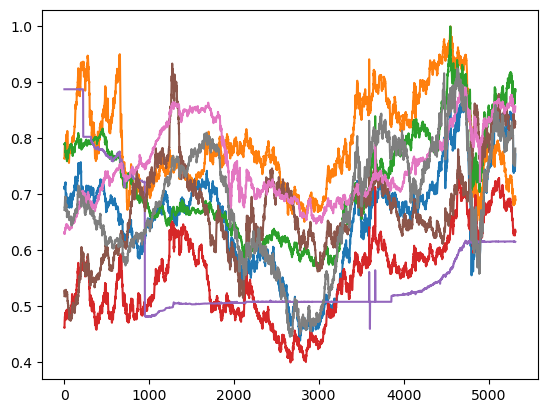

In [31]:
plt.plot(dataloader.train_dataset.scaled_data[:10000, :])

In [16]:
dataloader.train_dataset.scaler.std

array([0.13661142, 0.16153359, 0.11711549, 0.16886256, 0.02399484,
       0.00145765, 0.08283009, 0.11528425])

In [41]:
from torch_timeseries.experiments.nlinear_experiment import NLinearExperiment

experiment = NLinearExperiment(
        dataset_type="ExchangeRate",
        # data_path="../data",
        # normalization=False,
        optm_type="Adam",
        horizon=24,
        pred_len=1,
        batch_size=1024,
        device="cuda:3",
        windows=96,
        scaler_type="MaxAbsScaler",
)

experiment.run(1)

Using downloaded and verified file: ./data/exchange_rate/exchange_rate.csv
train steps: 5192
val steps: 1398
test steps: 641
torch.get_default_dtype() torch.float32
result directory exists: ./results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380
resuming from ./results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380/run_checkpoint.pth
run : 0 in seed: 1
+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| Linear.weight |     96     |
|  Linear.bias  |     1      |
+---------------+------------+
Total Trainable Params: 97
model parameters: 97
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2577.07it/s, epoch=1, loss=0.00117, lr=0.0003]


Epoch: 2 cost time: 2.0175940990448
Traininng loss : 0.0014396168796035151
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 733.91it/s]


vali_results: {'corr': 0.9895524382591248, 'mae': 0.03290016949176788, 'mse': 0.0014184332685545087, 'r2': -0.5445760488510132, 'r2_weighted': 0.40853995084762573}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 371.00it/s]


test_results: {'corr': 0.9863741993904114, 'mae': 0.03347155079245567, 'mse': 0.001391714671626687, 'r2': -1.0888773202896118, 'r2_weighted': -0.27773991227149963}
Validation loss decreased (0.001537 --> 0.001418).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2330.77it/s, epoch=2, loss=0.00138, lr=0.0003]


Epoch: 3 cost time: 7.911942481994629
Traininng loss : 0.0013698119825373094
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 848.69it/s]


vali_results: {'corr': 0.9894450306892395, 'mae': 0.031369563192129135, 'mse': 0.001316001289524138, 'r2': -0.43051788210868835, 'r2_weighted': 0.45125216245651245}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 347.67it/s]


test_results: {'corr': 0.9862997531890869, 'mae': 0.03159872069954872, 'mse': 0.0012660656357184052, 'r2': -0.8960824608802795, 'r2_weighted': -0.16238096356391907}
Validation loss decreased (0.001418 --> 0.001316).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1907.44it/s, epoch=3, loss=0.00135, lr=0.0003]


Epoch: 4 cost time: 14.171662092208862
Traininng loss : 0.001280241219016413
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 765.89it/s]


vali_results: {'corr': 0.9893838763237, 'mae': 0.02985585667192936, 'mse': 0.0012178191682323813, 'r2': -0.3139260411262512, 'r2_weighted': 0.4921923279762268}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 392.73it/s]


test_results: {'corr': 0.9862356781959534, 'mae': 0.02992461621761322, 'mse': 0.0011575459502637386, 'r2': -0.7274819016456604, 'r2_weighted': -0.06274854391813278}
Validation loss decreased (0.001316 --> 0.001218).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2219.23it/s, epoch=4, loss=0.00105, lr=0.000299]


Epoch: 5 cost time: 20.01235032081604
Traininng loss : 0.0011522934267607827
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 704.28it/s]


vali_results: {'corr': 0.9894916415214539, 'mae': 0.028318779543042183, 'mse': 0.0011193195823580027, 'r2': -0.19181139767169952, 'r2_weighted': 0.533264696598053}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 381.86it/s]


test_results: {'corr': 0.9863443970680237, 'mae': 0.028450733050704002, 'mse': 0.0010623055277392268, 'r2': -0.5778906941413879, 'r2_weighted': 0.024692147970199585}
Validation loss decreased (0.001218 --> 0.001119).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2313.94it/s, epoch=5, loss=0.00105, lr=0.000299]


Epoch: 6 cost time: 25.970123052597046
Traininng loss : 0.0010768120409920812
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 811.55it/s]


vali_results: {'corr': 0.9896200299263, 'mae': 0.02682807296514511, 'mse': 0.0010280520655214787, 'r2': -0.07618626952171326, 'r2_weighted': 0.5713215470314026}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 314.31it/s]


test_results: {'corr': 0.9864591360092163, 'mae': 0.027109229937195778, 'mse': 0.000978373340331018, 'r2': -0.444743275642395, 'r2_weighted': 0.10175065696239471}
Validation loss decreased (0.001119 --> 0.001028).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2315.46it/s, epoch=6, loss=0.00116, lr=0.000298] 


Epoch: 7 cost time: 32.01827883720398
Traininng loss : 0.0010260138660669327
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 775.91it/s]


vali_results: {'corr': 0.9896565675735474, 'mae': 0.025463035330176353, 'mse': 0.0009492809767834842, 'r2': 0.020481206476688385, 'r2_weighted': 0.604167640209198}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 379.04it/s]


test_results: {'corr': 0.9864879250526428, 'mae': 0.025771891698241234, 'mse': 0.0008991105132736266, 'r2': -0.32019686698913574, 'r2_weighted': 0.1745222508907318}
Validation loss decreased (0.001028 --> 0.000949).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2438.83it/s, epoch=7, loss=0.000837, lr=0.000297]


Epoch: 8 cost time: 37.69070482254028
Traininng loss : 0.0009145005024038255
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 696.67it/s]


vali_results: {'corr': 0.9896606802940369, 'mae': 0.024199342355132103, 'mse': 0.0008794487221166492, 'r2': 0.10405492037534714, 'r2_weighted': 0.6332863569259644}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 389.28it/s]


test_results: {'corr': 0.9864962100982666, 'mae': 0.024476876482367516, 'mse': 0.0008253696723841131, 'r2': -0.20519576966762543, 'r2_weighted': 0.2422240972518921}
Validation loss decreased (0.000949 --> 0.000879).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2190.99it/s, epoch=8, loss=0.000703, lr=0.000296]


Epoch: 9 cost time: 43.759726762771606
Traininng loss : 0.0008394605538342148
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 732.71it/s]


vali_results: {'corr': 0.9896482825279236, 'mae': 0.02304835245013237, 'mse': 0.0008181440061889589, 'r2': 0.17600466310977936, 'r2_weighted': 0.65884929895401}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 352.00it/s]


test_results: {'corr': 0.9864919185638428, 'mae': 0.023257065564393997, 'mse': 0.0007581723621115088, 'r2': -0.10112185031175613, 'r2_weighted': 0.3039183020591736}
Validation loss decreased (0.000879 --> 0.000818).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2317.59it/s, epoch=9, loss=0.000827, lr=0.000295]


Epoch: 10 cost time: 49.774264335632324
Traininng loss : 0.000810187445798268
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 787.42it/s]


vali_results: {'corr': 0.9896541237831116, 'mae': 0.021972311660647392, 'mse': 0.0007628034218214452, 'r2': 0.24191634356975555, 'r2_weighted': 0.6819252967834473}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 355.59it/s]


test_results: {'corr': 0.9864986538887024, 'mae': 0.022168105468153954, 'mse': 0.0006993688875809312, 'r2': -0.009557552635669708, 'r2_weighted': 0.3579059839248657}
Validation loss decreased (0.000818 --> 0.000763).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2520.93it/s, epoch=10, loss=0.000651, lr=0.000294]


Epoch: 11 cost time: 55.45751070976257
Traininng loss : 0.0007400675967801362
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 816.42it/s]


vali_results: {'corr': 0.9896726012229919, 'mae': 0.020976534113287926, 'mse': 0.0007132191676646471, 'r2': 0.30123910307884216, 'r2_weighted': 0.7026009559631348}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 326.93it/s]


test_results: {'corr': 0.9865151047706604, 'mae': 0.021173976361751556, 'mse': 0.0006473254179582, 'r2': 0.07165642082691193, 'r2_weighted': 0.4056873917579651}
Validation loss decreased (0.000763 --> 0.000713).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:01<00:00, 2771.80it/s, epoch=11, loss=0.000772, lr=0.000293]


Epoch: 12 cost time: 61.04782819747925
Traininng loss : 0.0007208621245808899
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 862.64it/s]


vali_results: {'corr': 0.9896957874298096, 'mae': 0.020057313144207, 'mse': 0.0006691004382446408, 'r2': 0.3540622591972351, 'r2_weighted': 0.7209976315498352}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 352.97it/s]


test_results: {'corr': 0.9865346550941467, 'mae': 0.020269522443413734, 'mse': 0.0006011886289343238, 'r2': 0.14372320473194122, 'r2_weighted': 0.4480458199977875}
Validation loss decreased (0.000713 --> 0.000669).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2079.85it/s, epoch=12, loss=0.000605, lr=0.000291]


Epoch: 13 cost time: 67.02563524246216
Traininng loss : 0.0006615927074259768
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 831.96it/s]


vali_results: {'corr': 0.9896987080574036, 'mae': 0.019231973215937614, 'mse': 0.0006308796582743526, 'r2': 0.3991226851940155, 'r2_weighted': 0.736935019493103}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 424.99it/s]


test_results: {'corr': 0.9865384697914124, 'mae': 0.019442589953541756, 'mse': 0.0005601550219580531, 'r2': 0.2075442522764206, 'r2_weighted': 0.4857189953327179}
Validation loss decreased (0.000669 --> 0.000631).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2104.91it/s, epoch=13, loss=0.000615, lr=0.000289]


Epoch: 14 cost time: 72.73507905006409
Traininng loss : 0.0006341402962182959
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 706.86it/s]


vali_results: {'corr': 0.9896692633628845, 'mae': 0.01852666586637497, 'mse': 0.0005992548540234566, 'r2': 0.4353277087211609, 'r2_weighted': 0.7501220107078552}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 377.35it/s]


test_results: {'corr': 0.9865142107009888, 'mae': 0.01869564689695835, 'mse': 0.0005241319886408746, 'r2': 0.26288601756095886, 'r2_weighted': 0.5187918543815613}
Validation loss decreased (0.000631 --> 0.000599).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2295.27it/s, epoch=14, loss=0.000641, lr=0.000288]


Epoch: 15 cost time: 78.72110772132874
Traininng loss : 0.0006133065132113794
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 663.86it/s]


vali_results: {'corr': 0.9896730184555054, 'mae': 0.017858153209090233, 'mse': 0.0005699833272956312, 'r2': 0.4697868227958679, 'r2_weighted': 0.7623276114463806}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 340.93it/s]


test_results: {'corr': 0.986518383026123, 'mae': 0.018033305183053017, 'mse': 0.0004929097485728562, 'r2': 0.3115348219871521, 'r2_weighted': 0.5474570989608765}
Validation loss decreased (0.000599 --> 0.000570).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:01<00:00, 2654.52it/s, epoch=15, loss=0.000832, lr=0.000286]


Epoch: 16 cost time: 84.72849869728088
Traininng loss : 0.0006208715688747665
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 737.55it/s]


vali_results: {'corr': 0.9897132515907288, 'mae': 0.017225472256541252, 'mse': 0.0005428430158644915, 'r2': 0.5025774240493774, 'r2_weighted': 0.7736446857452393}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 355.90it/s]


test_results: {'corr': 0.9865545630455017, 'mae': 0.017445974051952362, 'mse': 0.00046590366400778294, 'r2': 0.35441872477531433, 'r2_weighted': 0.572251558303833}
Validation loss decreased (0.000570 --> 0.000543).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2091.30it/s, epoch=16, loss=0.000417, lr=0.000284]


Epoch: 17 cost time: 90.96946549415588
Traininng loss : 0.0005375223505931596
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 738.75it/s]


vali_results: {'corr': 0.9897128939628601, 'mae': 0.016703570261597633, 'mse': 0.000521186098922044, 'r2': 0.5273962020874023, 'r2_weighted': 0.7826752066612244}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 370.24it/s]


test_results: {'corr': 0.9865548610687256, 'mae': 0.0169051680713892, 'mse': 0.0004417543241288513, 'r2': 0.39165136218070984, 'r2_weighted': 0.594423234462738}
Validation loss decreased (0.000543 --> 0.000521).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2132.66it/s, epoch=17, loss=0.000454, lr=0.000281]


Epoch: 18 cost time: 97.09079027175903
Traininng loss : 0.0005271379826202368
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 707.81it/s]


vali_results: {'corr': 0.9897171258926392, 'mae': 0.01624881476163864, 'mse': 0.0005028083105571568, 'r2': 0.5485470294952393, 'r2_weighted': 0.7903383374214172}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 405.91it/s]


test_results: {'corr': 0.9865588545799255, 'mae': 0.01643984206020832, 'mse': 0.00042154535185545683, 'r2': 0.42294782400131226, 'r2_weighted': 0.612977147102356}
Validation loss decreased (0.000521 --> 0.000503).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2282.54it/s, epoch=18, loss=0.000501, lr=0.000279]


Epoch: 19 cost time: 102.97880387306213
Traininng loss : 0.00052074903214816
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 794.20it/s]


vali_results: {'corr': 0.9897622466087341, 'mae': 0.015804700553417206, 'mse': 0.0004849785182159394, 'r2': 0.5701332688331604, 'r2_weighted': 0.7977730631828308}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 374.16it/s]


test_results: {'corr': 0.986595869064331, 'mae': 0.016025569289922714, 'mse': 0.00040400566649623215, 'r2': 0.4511551260948181, 'r2_weighted': 0.6290804743766785}
Validation loss decreased (0.000503 --> 0.000485).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2319.74it/s, epoch=19, loss=0.000511, lr=0.000277]


Epoch: 20 cost time: 108.73886060714722
Traininng loss : 0.0005111362164219221
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 770.23it/s]


vali_results: {'corr': 0.9897902607917786, 'mae': 0.015425140038132668, 'mse': 0.00047023320803418756, 'r2': 0.5877690315246582, 'r2_weighted': 0.8039215803146362}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 369.68it/s]


test_results: {'corr': 0.9866151213645935, 'mae': 0.01565990224480629, 'mse': 0.0003888779610861093, 'r2': 0.47539016604423523, 'r2_weighted': 0.6429692506790161}
Validation loss decreased (0.000485 --> 0.000470).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2163.72it/s, epoch=20, loss=0.00046, lr=0.000274] 


Epoch: 21 cost time: 114.73243689537048
Traininng loss : 0.0004936987194620693
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 770.22it/s]


vali_results: {'corr': 0.9897967576980591, 'mae': 0.015119760297238827, 'mse': 0.0004586433351505548, 'r2': 0.6006654500961304, 'r2_weighted': 0.8087543845176697}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 332.64it/s]


test_results: {'corr': 0.9866208434104919, 'mae': 0.015331626869738102, 'mse': 0.00037559744669124484, 'r2': 0.49577540159225464, 'r2_weighted': 0.6551621556282043}
Validation loss decreased (0.000470 --> 0.000459).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:01<00:00, 2619.50it/s, epoch=21, loss=0.000489, lr=0.000271]


Epoch: 22 cost time: 120.50554037094116
Traininng loss : 0.0004895596017983431
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 736.68it/s]


vali_results: {'corr': 0.9897820949554443, 'mae': 0.014874018728733063, 'mse': 0.00044964480912312865, 'r2': 0.6099048852920532, 'r2_weighted': 0.8125065565109253}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 357.64it/s]


test_results: {'corr': 0.9866116642951965, 'mae': 0.015042755752801895, 'mse': 0.0003641839721240103, 'r2': 0.5126550197601318, 'r2_weighted': 0.6656410098075867}
Validation loss decreased (0.000459 --> 0.000450).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2285.24it/s, epoch=22, loss=0.000492, lr=0.000269]


Epoch: 23 cost time: 126.51829767227173
Traininng loss : 0.000482821303497379
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 831.34it/s]


vali_results: {'corr': 0.9897545576095581, 'mae': 0.014674248173832893, 'mse': 0.00044263264862820506, 'r2': 0.6168246865272522, 'r2_weighted': 0.8154304623603821}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 397.76it/s]


test_results: {'corr': 0.9865896105766296, 'mae': 0.014795104041695595, 'mse': 0.0003547108790371567, 'r2': 0.5264012217521667, 'r2_weighted': 0.6743382215499878}
Validation loss decreased (0.000450 --> 0.000443).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2125.78it/s, epoch=23, loss=0.000515, lr=0.000266]


Epoch: 24 cost time: 132.3107614517212
Traininng loss : 0.000480264662958992
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 771.08it/s]


vali_results: {'corr': 0.9897321462631226, 'mae': 0.014509201981127262, 'mse': 0.00043679276132024825, 'r2': 0.6227129697799683, 'r2_weighted': 0.8178656101226807}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 445.89it/s]


test_results: {'corr': 0.9865683913230896, 'mae': 0.014588836580514908, 'mse': 0.0003469275252427906, 'r2': 0.5377474427223206, 'r2_weighted': 0.6814841628074646}
Validation loss decreased (0.000443 --> 0.000437).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2228.78it/s, epoch=24, loss=0.00053, lr=0.000263] 


Epoch: 25 cost time: 137.94883608818054
Traininng loss : 0.0004779657853456835
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 738.47it/s]


vali_results: {'corr': 0.9897686243057251, 'mae': 0.014317533001303673, 'mse': 0.00042935681995004416, 'r2': 0.6313133239746094, 'r2_weighted': 0.8209663033485413}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 356.09it/s]


test_results: {'corr': 0.9866014122962952, 'mae': 0.014396114274859428, 'mse': 0.0003395118110347539, 'r2': 0.5497506856918335, 'r2_weighted': 0.6882925629615784}
Validation loss decreased (0.000437 --> 0.000429).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2258.27it/s, epoch=25, loss=0.000457, lr=0.000259]


Epoch: 26 cost time: 144.00029492378235
Traininng loss : 0.00046259705171299476
Evaluating .... 


100%|██████████| 1398/1398 [00:01<00:00, 718.73it/s]


vali_results: {'corr': 0.9897782206535339, 'mae': 0.014178608544170856, 'mse': 0.0004241613205522299, 'r2': 0.6369552612304688, 'r2_weighted': 0.8231326937675476}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 286.15it/s]


test_results: {'corr': 0.9866097569465637, 'mae': 0.014239818789064884, 'mse': 0.00033363531110808253, 'r2': 0.558879017829895, 'r2_weighted': 0.6936877965927124}
Validation loss decreased (0.000429 --> 0.000424).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1968.95it/s, epoch=26, loss=0.000447, lr=0.000256]


Epoch: 27 cost time: 150.89294981956482
Traininng loss : 0.00045785393740516156
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 604.84it/s]


vali_results: {'corr': 0.989813506603241, 'mae': 0.014042210765182972, 'mse': 0.00041870118002407253, 'r2': 0.6433271169662476, 'r2_weighted': 0.8254095315933228}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 253.85it/s]


test_results: {'corr': 0.9866389036178589, 'mae': 0.014096942730247974, 'mse': 0.0003282122197560966, 'r2': 0.5678391456604004, 'r2_weighted': 0.6986667513847351}
Validation loss decreased (0.000424 --> 0.000419).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2375.68it/s, epoch=27, loss=0.000508, lr=0.000253]


Epoch: 28 cost time: 157.98683166503906
Traininng loss : 0.00046478139120154083
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 675.75it/s]


vali_results: {'corr': 0.9898374080657959, 'mae': 0.013939396478235722, 'mse': 0.0004145512357354164, 'r2': 0.648008406162262, 'r2_weighted': 0.8271399140357971}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 268.06it/s]


test_results: {'corr': 0.9866567254066467, 'mae': 0.013976306654512882, 'mse': 0.00032374716829508543, 'r2': 0.5749505758285522, 'r2_weighted': 0.7027661800384521}
Validation loss decreased (0.000419 --> 0.000415).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 2185.07it/s, epoch=28, loss=0.000354, lr=0.000249]


Epoch: 29 cost time: 164.8750376701355
Traininng loss : 0.00043858226854354143
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 628.40it/s]


vali_results: {'corr': 0.98980712890625, 'mae': 0.013896044343709946, 'mse': 0.00041335818241350353, 'r2': 0.6483554840087891, 'r2_weighted': 0.8276374340057373}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 234.80it/s]


test_results: {'corr': 0.9866310954093933, 'mae': 0.013895081356167793, 'mse': 0.0003208806738257408, 'r2': 0.5781968832015991, 'r2_weighted': 0.70539790391922}
Validation loss decreased (0.000415 --> 0.000413).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1981.99it/s, epoch=29, loss=0.000518, lr=0.000246]


Epoch: 30 cost time: 172.49562978744507
Traininng loss : 0.00046222133581371355
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 602.03it/s]


vali_results: {'corr': 0.9897794723510742, 'mae': 0.013859291560947895, 'mse': 0.0004123841936234385, 'r2': 0.6488162875175476, 'r2_weighted': 0.8280435800552368}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 258.35it/s]


test_results: {'corr': 0.9866061806678772, 'mae': 0.013832315802574158, 'mse': 0.0003187159600201994, 'r2': 0.5808924436569214, 'r2_weighted': 0.7073853611946106}
Validation loss decreased (0.000413 --> 0.000412).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:04<00:00, 1169.42it/s, epoch=30, loss=0.000569, lr=0.000242]


Epoch: 31 cost time: 181.79243183135986
Traininng loss : 0.0004687956679845229
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 604.18it/s]


vali_results: {'corr': 0.9897704720497131, 'mae': 0.013816014863550663, 'mse': 0.0004108656430616975, 'r2': 0.6501871347427368, 'r2_weighted': 0.8286767601966858}
Testing .... 


100%|██████████| 641/641 [00:03<00:00, 198.87it/s]


test_results: {'corr': 0.9865987300872803, 'mae': 0.013773287646472454, 'mse': 0.00031662004766985774, 'r2': 0.5839971303939819, 'r2_weighted': 0.7093095779418945}
Validation loss decreased (0.000412 --> 0.000411).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1568.45it/s, epoch=31, loss=0.000551, lr=0.000238]


Epoch: 32 cost time: 190.70813035964966
Traininng loss : 0.0004649471181134383
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 652.26it/s]


vali_results: {'corr': 0.9897699952125549, 'mae': 0.013771215453743935, 'mse': 0.00040913905831985176, 'r2': 0.6518515348434448, 'r2_weighted': 0.8293967247009277}
Testing .... 


100%|██████████| 641/641 [00:03<00:00, 212.66it/s]


test_results: {'corr': 0.9865993857383728, 'mae': 0.013713291846215725, 'mse': 0.0003144938964396715, 'r2': 0.587286114692688, 'r2_weighted': 0.7112616300582886}
Validation loss decreased (0.000411 --> 0.000409).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1646.73it/s, epoch=32, loss=0.000632, lr=0.000234]


Epoch: 33 cost time: 199.08341073989868
Traininng loss : 0.000476298116457959
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 577.52it/s]


vali_results: {'corr': 0.9897979497909546, 'mae': 0.013713302090764046, 'mse': 0.00040638813516125083, 'r2': 0.6549195051193237, 'r2_weighted': 0.8305436968803406}
Testing .... 


100%|██████████| 641/641 [00:03<00:00, 188.97it/s]


test_results: {'corr': 0.9866258502006531, 'mae': 0.013643302023410797, 'mse': 0.00031189509900286794, 'r2': 0.5917714834213257, 'r2_weighted': 0.7136476039886475}
Validation loss decreased (0.000409 --> 0.000406).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1617.84it/s, epoch=33, loss=0.000466, lr=0.00023]


Epoch: 34 cost time: 208.17611169815063
Traininng loss : 0.0004495462490012869
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 541.78it/s]


vali_results: {'corr': 0.9897951483726501, 'mae': 0.013686145655810833, 'mse': 0.00040528515819460154, 'r2': 0.6558489203453064, 'r2_weighted': 0.831003725528717}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 329.65it/s]


test_results: {'corr': 0.9866222739219666, 'mae': 0.013594734482467175, 'mse': 0.0003102775663137436, 'r2': 0.5940390229225159, 'r2_weighted': 0.7151327133178711}
Validation loss decreased (0.000406 --> 0.000405).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1388.87it/s, epoch=34, loss=0.000543, lr=0.000226]


Epoch: 35 cost time: 216.5107502937317
Traininng loss : 0.0004608807648764923
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 539.51it/s]


vali_results: {'corr': 0.9897900223731995, 'mae': 0.013666572980582714, 'mse': 0.0004045162058901042, 'r2': 0.6564075946807861, 'r2_weighted': 0.8313243389129639}
Testing .... 


100%|██████████| 641/641 [00:01<00:00, 340.80it/s]


test_results: {'corr': 0.9866170287132263, 'mae': 0.013555270619690418, 'mse': 0.0003089960664510727, 'r2': 0.5958313941955566, 'r2_weighted': 0.7163091897964478}
Validation loss decreased (0.000405 --> 0.000405).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1768.91it/s, epoch=35, loss=0.000448, lr=0.000222]


Epoch: 36 cost time: 223.98563385009766
Traininng loss : 0.0004455083884143581
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 668.41it/s]


vali_results: {'corr': 0.9898478984832764, 'mae': 0.013610487803816795, 'mse': 0.00040120678022503853, 'r2': 0.6605257987976074, 'r2_weighted': 0.8327043056488037}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 295.72it/s]


test_results: {'corr': 0.9866682291030884, 'mae': 0.013491570018231869, 'mse': 0.00030646505183540285, 'r2': 0.6008673310279846, 'r2_weighted': 0.7186329364776611}
Validation loss decreased (0.000405 --> 0.000401).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1441.22it/s, epoch=36, loss=0.000352, lr=0.000218]


Epoch: 37 cost time: 231.92354607582092
Traininng loss : 0.0004302006564103067
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 541.05it/s]


vali_results: {'corr': 0.9898593425750732, 'mae': 0.013589932583272457, 'mse': 0.0004000501648988575, 'r2': 0.6617945432662964, 'r2_weighted': 0.8331865668296814}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 242.10it/s]


test_results: {'corr': 0.9866777658462524, 'mae': 0.013458197005093098, 'mse': 0.0003052663232665509, 'r2': 0.6029890775680542, 'r2_weighted': 0.719733476638794}
Validation loss decreased (0.000401 --> 0.000400).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1470.52it/s, epoch=37, loss=0.000509, lr=0.000214]


Epoch: 38 cost time: 240.73214149475098
Traininng loss : 0.0004541807963202397
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 529.08it/s]


vali_results: {'corr': 0.9898456335067749, 'mae': 0.013590812683105469, 'mse': 0.00040025755879469216, 'r2': 0.6611618995666504, 'r2_weighted': 0.8331000804901123}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 274.34it/s]


test_results: {'corr': 0.9866661429405212, 'mae': 0.013444745913147926, 'mse': 0.0003049189399462193, 'r2': 0.6029763221740723, 'r2_weighted': 0.7200524806976318}
EarlyStopping counter: 1 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1318.78it/s, epoch=38, loss=0.000507, lr=0.00021]


Epoch: 39 cost time: 249.6957550048828
Traininng loss : 0.00045343841581294936
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 501.79it/s]


vali_results: {'corr': 0.9898251891136169, 'mae': 0.01359630934894085, 'mse': 0.00040076099685393274, 'r2': 0.6602035760879517, 'r2_weighted': 0.8328901529312134}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 290.51it/s]


test_results: {'corr': 0.986648440361023, 'mae': 0.013437801040709019, 'mse': 0.0003048317157663405, 'r2': 0.6025918126106262, 'r2_weighted': 0.7201325297355652}
EarlyStopping counter: 2 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1484.93it/s, epoch=39, loss=0.000585, lr=0.000205]


Epoch: 40 cost time: 258.3241581916809
Traininng loss : 0.00046538082824554294
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 470.94it/s]


vali_results: {'corr': 0.9898101091384888, 'mae': 0.013598521240055561, 'mse': 0.00040100645856000483, 'r2': 0.6596283316612244, 'r2_weighted': 0.8327879309654236}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 242.59it/s]


test_results: {'corr': 0.9866344332695007, 'mae': 0.013427654281258583, 'mse': 0.0003045914927497506, 'r2': 0.602575421333313, 'r2_weighted': 0.7203531265258789}
EarlyStopping counter: 3 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1652.82it/s, epoch=40, loss=0.000519, lr=0.000201]


Epoch: 41 cost time: 267.12784123420715
Traininng loss : 0.0004547392842747892
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 631.88it/s]


vali_results: {'corr': 0.9898506999015808, 'mae': 0.013569185510277748, 'mse': 0.0003989253309555352, 'r2': 0.662202000617981, 'r2_weighted': 0.8336556553840637}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 259.95it/s]


test_results: {'corr': 0.9866694808006287, 'mae': 0.013385757803916931, 'mse': 0.0003029810031875968, 'r2': 0.605674684047699, 'r2_weighted': 0.7218316793441772}
Validation loss decreased (0.000400 --> 0.000399).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1940.68it/s, epoch=41, loss=0.000428, lr=0.000196]


Epoch: 42 cost time: 274.53662180900574
Traininng loss : 0.0004404920424955587
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 551.16it/s]


vali_results: {'corr': 0.9898430109024048, 'mae': 0.013570600189268589, 'mse': 0.0003990337427239865, 'r2': 0.6618571281433105, 'r2_weighted': 0.8336103558540344}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 257.93it/s]


test_results: {'corr': 0.9866615533828735, 'mae': 0.013375947251915932, 'mse': 0.00030272803269326687, 'r2': 0.6056886911392212, 'r2_weighted': 0.7220638990402222}
EarlyStopping counter: 1 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1874.53it/s, epoch=42, loss=0.000366, lr=0.000192]


Epoch: 43 cost time: 282.38506984710693
Traininng loss : 0.00043066397968990106
Evaluating .... 


100%|██████████| 1398/1398 [00:03<00:00, 465.46it/s]


vali_results: {'corr': 0.9898362755775452, 'mae': 0.013571363873779774, 'mse': 0.0003990900586359203, 'r2': 0.6616107225418091, 'r2_weighted': 0.8335869312286377}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 226.13it/s]


test_results: {'corr': 0.9866551160812378, 'mae': 0.01336685661226511, 'mse': 0.0003024835605174303, 'r2': 0.6058491468429565, 'r2_weighted': 0.7222883701324463}
EarlyStopping counter: 2 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1605.54it/s, epoch=43, loss=0.000344, lr=0.000187]


Epoch: 44 cost time: 291.5002119541168
Traininng loss : 0.00042717098161422956
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 474.38it/s]


vali_results: {'corr': 0.989845871925354, 'mae': 0.013563228771090508, 'mse': 0.0003984695940744132, 'r2': 0.6622796058654785, 'r2_weighted': 0.8338456749916077}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 291.01it/s]


test_results: {'corr': 0.9866631031036377, 'mae': 0.01334895845502615, 'mse': 0.00030184772913344204, 'r2': 0.6069414019584656, 'r2_weighted': 0.7228721380233765}
Validation loss decreased (0.000399 --> 0.000398).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1417.88it/s, epoch=44, loss=0.000396, lr=0.000183]


Epoch: 45 cost time: 300.3616530895233
Traininng loss : 0.0004350280117553969
Evaluating .... 


100%|██████████| 1398/1398 [00:03<00:00, 456.99it/s]


vali_results: {'corr': 0.9898623824119568, 'mae': 0.013552422635257244, 'mse': 0.0003976348671130836, 'r2': 0.6633033752441406, 'r2_weighted': 0.8341937065124512}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 261.05it/s]


test_results: {'corr': 0.986676812171936, 'mae': 0.013330935500562191, 'mse': 0.0003011637891177088, 'r2': 0.6082420349121094, 'r2_weighted': 0.72350013256073}
Validation loss decreased (0.000398 --> 0.000398).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1371.18it/s, epoch=45, loss=0.000384, lr=0.000178]


Epoch: 46 cost time: 309.7356970310211
Traininng loss : 0.0004331580566940829
Evaluating .... 


100%|██████████| 1398/1398 [00:03<00:00, 433.13it/s]


vali_results: {'corr': 0.9898940920829773, 'mae': 0.013534014113247395, 'mse': 0.0003961662296205759, 'r2': 0.6652748584747314, 'r2_weighted': 0.8348061442375183}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 310.69it/s]


test_results: {'corr': 0.9867021441459656, 'mae': 0.013303762301802635, 'mse': 0.00030012850766070187, 'r2': 0.6104846000671387, 'r2_weighted': 0.7244505882263184}
Validation loss decreased (0.000398 --> 0.000396).  Saving model ...
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1552.87it/s, epoch=46, loss=0.000533, lr=0.000173]


Epoch: 47 cost time: 318.4269018173218
Traininng loss : 0.00045620962434137863
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 557.36it/s]


vali_results: {'corr': 0.9898834228515625, 'mae': 0.013537847436964512, 'mse': 0.00039646567893214524, 'r2': 0.6646960377693176, 'r2_weighted': 0.8346812725067139}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 245.25it/s]


test_results: {'corr': 0.9866945147514343, 'mae': 0.013303856365382671, 'mse': 0.00030016127857379615, 'r2': 0.6101601123809814, 'r2_weighted': 0.7244204878807068}
EarlyStopping counter: 1 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1827.41it/s, epoch=47, loss=0.000497, lr=0.000169]


Epoch: 48 cost time: 326.44878578186035
Traininng loss : 0.0004504631942836568
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 578.18it/s]


vali_results: {'corr': 0.9898648262023926, 'mae': 0.01354670338332653, 'mse': 0.00039713806472718716, 'r2': 0.6636416912078857, 'r2_weighted': 0.8344008922576904}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 272.83it/s]


test_results: {'corr': 0.9866788387298584, 'mae': 0.013309366069734097, 'mse': 0.00030043901642784476, 'r2': 0.609207034111023, 'r2_weighted': 0.7241654992103577}
EarlyStopping counter: 2 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1888.23it/s, epoch=48, loss=0.000389, lr=0.000164]


Epoch: 49 cost time: 334.04401445388794
Traininng loss : 0.00043355543554450077
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 536.89it/s]


vali_results: {'corr': 0.9898467063903809, 'mae': 0.013555807992815971, 'mse': 0.0003977978485636413, 'r2': 0.6626774072647095, 'r2_weighted': 0.8341257572174072}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 250.04it/s]


test_results: {'corr': 0.986662745475769, 'mae': 0.013315862976014614, 'mse': 0.0003007578197866678, 'r2': 0.6082936525344849, 'r2_weighted': 0.7238727807998657}
EarlyStopping counter: 3 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:03<00:00, 1581.36it/s, epoch=49, loss=0.000423, lr=0.000159]


Epoch: 50 cost time: 342.56943225860596
Traininng loss : 0.0004387795488582924
Evaluating .... 


100%|██████████| 1398/1398 [00:03<00:00, 443.42it/s]


vali_results: {'corr': 0.9898530840873718, 'mae': 0.01355058141052723, 'mse': 0.00039739132625982165, 'r2': 0.6631272435188293, 'r2_weighted': 0.8342952728271484}
Testing .... 


100%|██████████| 641/641 [00:03<00:00, 197.29it/s]


test_results: {'corr': 0.9866691827774048, 'mae': 0.013307083398103714, 'mse': 0.0003004148602485657, 'r2': 0.6089500188827515, 'r2_weighted': 0.7241877317428589}
EarlyStopping counter: 4 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 5192/5192 [00:02<00:00, 1828.82it/s, epoch=50, loss=0.000404, lr=0.000155]


Epoch: 51 cost time: 351.8705105781555
Traininng loss : 0.0004359299297599743
Evaluating .... 


100%|██████████| 1398/1398 [00:02<00:00, 601.84it/s]


vali_results: {'corr': 0.9898386597633362, 'mae': 0.013557330705225468, 'mse': 0.0003978941240347922, 'r2': 0.662400484085083, 'r2_weighted': 0.8340856432914734}
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 233.89it/s]


test_results: {'corr': 0.9866565465927124, 'mae': 0.013311722315847874, 'mse': 0.0003006586921401322, 'r2': 0.6083047389984131, 'r2_weighted': 0.7239637970924377}
EarlyStopping counter: 5 out of 5
Saving run checkpoint to './results/runs/NLinear/ExchangeRate/w96h24s1/e3ba825aa316ed2d260f316cf7f99380'.
Run state saved ... 
loss no decreased for 5 epochs,  early stopping ....
Testing .... 


100%|██████████| 641/641 [00:02<00:00, 213.92it/s]

test_results: {'corr': 0.9867021441459656, 'mae': 0.013303762301802635, 'mse': 0.00030012850766070187, 'r2': 0.6104846000671387, 'r2_weighted': 0.7244505882263184}


{'corr': 0.9867021441459656,
 'mae': 0.013303762301802635,
 'mse': 0.00030012850766070187,
 'r2': 0.6104846000671387,
 'r2_weighted': 0.7244505882263184}

# Model

In [ ]:



class Model(nn.Module):
    def __init__(self, seq_len, pred_len, num_features, device, individual=False, normalization=True):
        super(Model, self).__init__()
        # inputs:
        # batch_x: (B, N, T)
        
        
        hidden_dim = 16
        z_dim=16
        self.num_features = num_features
        self.normalization = normalization
        self.linears = nn.ModuleList()
        
        for i in range(num_features):
            self.linears.append(
                nn.Sequential(
                    nn.Linear(seq_len, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, z_dim),
                )
            )
    
    def forward(self, x):
        # batch_x: (B, N, T)
        # out: (B, N, O)
        if self.normalization:
            seq_last = x[:,:,-1:].detach()
            # x = x - seq_last


        xs = []
        for i in range(self.num_features):
            xs.append(self.linears[i](x[:, i, :])) # x[:, i, :] =  
        
        
        
        if self.normalization:
            x = x + seq_last

        return x
    
    